# Test Gradient CIPL

In [1]:
%matplotlib inline
import os
import sys

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from sklearn import svm, cross_validation
from theano import config, shared
import theano.tensor as T

sys.path.insert(0, os.path.abspath('../..'))

plt.style.use('ggplot')  # Style plots

from deepensemble.utils import *


## Generate Data:

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=6, n_informative=4,
                           n_classes=2, n_clusters_per_class=2, random_state=0)

classes_labels = [d for d in range(2)]
X = np.array(X, dtype=config.floatX)
y = np.array(y[:,np.newaxis], dtype=config.floatX)

# Silverman
s = ITLFunctions.silverman(shared(np.array(y)), len(y), len(classes_labels)).eval()

## Generate Linear Model

In [3]:
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.utils import ActivationFunctions

net1 = Sequential('Net Linear 1', "classifier", classes_labels)
net1.add_layer(Dense(n_input=X.shape[1], n_output=y.shape[1], activation=ActivationFunctions.linear))

In [4]:
net1.append_cost(mse, name='MSE')
net1.set_update(sgd, name='SGD', learning_rate=0.1)
net1.compile()

Start Compile Net Linear 1  - elapsed: 0.46 [s]


In [5]:
metric1 = net1.fit(X, y, early_stop=False)

Net Linear 1 - fold: 1, epoch:[####################] 100/100 elapsed: 0.47[s] - left: 0.00[s] | score: 0.7679 / 0.7604


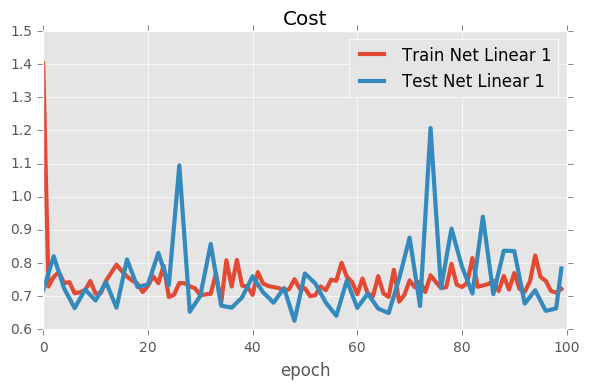

In [6]:
metric1.plot_cost(max_epoch=100)
plt.tight_layout()

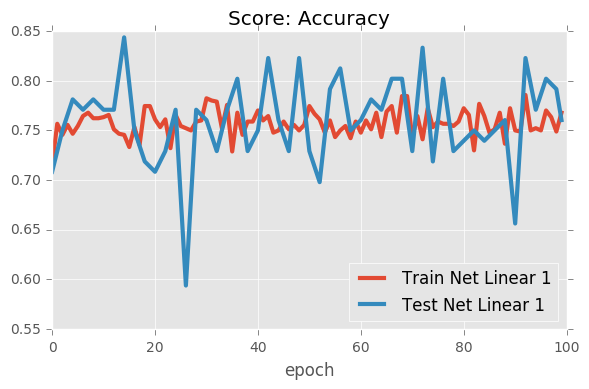

In [7]:
metric1.plot_scores(max_epoch=100)
plt.tight_layout()

## Generate Ensemble Linear Models

In [8]:
from deepensemble.models import EnsembleModel
from deepensemble.combiner import PluralityVotingCombiner

mse_first_epoch = True
is_cip_full = True
dist = 'CS-CIP'
beta = 0.3
lamb = 0.6

sp = 1.5 * s
sm = 0.5 * s
i = shared(0.0, 'i')
si = sp * T.power((sm / sp), i)

def _proc_pre_training(_ensemble, _input, _target, net0, batch_size, max_epoch):
    state_log = Logger().is_log_activate()
    Logger().log_disable()

    for net in _ensemble.get_models():
        net0.fit(_input, _target, batch_size=batch_size, max_epoch=max_epoch, early_stop=False)
        params = net0.save_params()
        net.load_params(params)

    if state_log:
        Logger().log_enable()

if is_cip_full:
    cost_models = None
    name_cost_models = None
    params_cost_models = None
else:
    cost_models = cip_relevancy
    name_cost_models = 'CIP Relevancy'
    params_cost_models = {'s': si, 'dist': dist}

ensemble = EnsembleModel(name='Ensemble CIPL')

for i in range(2):
    net = Sequential('Net %d' % (i + 1), "classifier", classes_labels)
    net.add_layer(Dense(n_input=X.shape[1], n_output=y.shape[1], activation=ActivationFunctions.linear))
    
    if cost_models is not None:
        net.append_cost(cost_models, name=name_cost_models, **params_cost_models)

    net.set_update(sgd, name='SGD', learning_rate=0.1)
    
    ensemble.append_model(net)

if mse_first_epoch:
    Logger().log_disable()
    net0 = Sequential('Net Linear 1', "classifier", classes_labels)
    net0.add_layer(Dense(n_input=X.shape[1], n_output=y.shape[1], activation=ActivationFunctions.linear))
    net0.append_cost(mse, name='MSE')
    net0.set_update(sgd, name='SGD', learning_rate=0.01)
    net0.compile(fast=True)
    Logger().log_enable()

    ensemble.set_pre_training(proc_pre_training=_proc_pre_training,
                              params={'net0': net0, 'batch_size': 32, 'max_epoch': 30})

if is_cip_full:
    ensemble.append_cost(fun_cost=cip_full, name="CIP Full", s=s, dist=dist)
else:
    if beta != 0.0:
        ensemble.add_cost_ensemble(fun_cost=cip_redundancy, name="CIP Redundancy", beta=beta, s=s, dist=dist)

    if lamb != 0.0:
        ensemble.add_cost_ensemble(fun_cost=cip_synergy, name="CIP Synergy", lamb=lamb, s=s, dist=dist)

ensemble.set_combiner(PluralityVotingCombiner())
ensemble.append_update(annealing, 'Annealing', max_epoch=100, _i=i)
ensemble.set_update(sgd, name='SGD', learning_rate=0.1)

ensemble.append_score(mutual_information_cs, name='Ics')

In [9]:
ensemble.compile(fast=False)

Start Compile Ensemble CIPL  - elapsed: 4.03 [s]


In [10]:
metric2 = ensemble.fit(X, y, early_stop=False)

Ensemble CIPL - fold: 1, epoch:[####################] 100/100 elapsed: 2.07[s] - left: 0.00[s] | score: 0.6317 / 0.6250


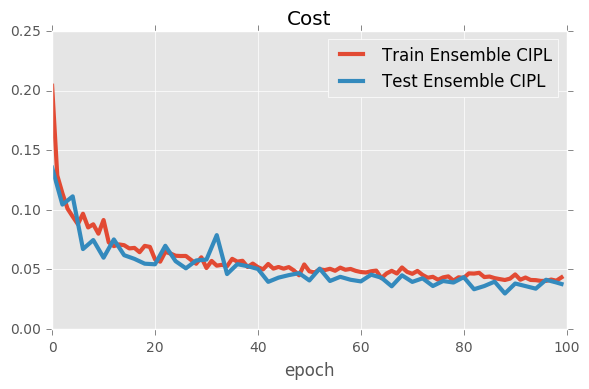

In [11]:
metric2.plot_cost(max_epoch=100)
plt.tight_layout()

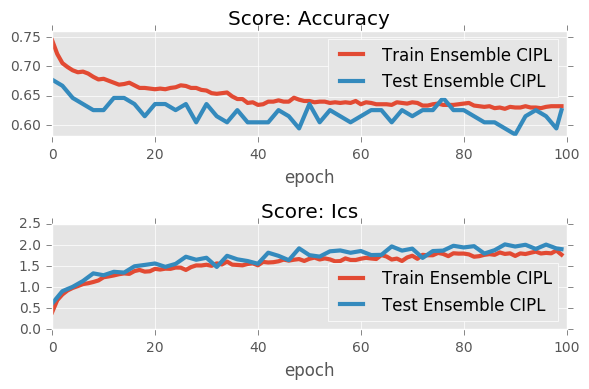

In [12]:
metric2.plot_scores(max_epoch=100)
plt.tight_layout()